**Lab2-DL: A5-MNIST-MLP.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

_MNIST-klassifisering med multilags perseptron (MLP) – din første nevrale nettverk-modell_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A5-MNIST-MLP.ipynb)

Sist oppdatert: 2025-12-04, A. Lundervold

Bruk `elmed219-2026` conda-miljøet eller Google Colab

---

## Fra Random Forest til nevrale nettverk

### Hvor er vi i læringsreisen?

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  A4: Random     │    │  A5: MLP        │    │  A6: CNN        │
│  Forest         │ →  │  (Nevrale nett) │ →  │  (Dyp læring)   │
│ ≈92% nøyaktighet│    │ ≈97% nøyaktighet│    │ ≈99% nøyaktighet│
└─────────────────┘    └─────────────────┘    └─────────────────┘
     BASELINE         ▶▶ DU ER HER ◀◀          STATE-OF-ART
```

### Hva er et MLP (Multilags Perseptron)?

Et **MLP** er et nevralt nettverk med:
- **Input-lag**: Tar imot data (784 piksler)
- **Skjulte lag**: Lærer abstrakte mønstre
- **Output-lag**: Gir prediksjoner (10 klasser)

| Egenskap | Random Forest | MLP |
|----------|---------------|-----|
| **Læring** | Beslutningstrær | Gradient descent |
| **Representasjon** | Faste features | Lærte features |
| **Ikke-linearitet** | Splitt-basert | Aktiveringsfunksjoner |
| **Parametre** | Trehøyde, antall trær | Vekter, biaser |

### Medisinsk analogi

Tenk på MLP som et **diagnoseteam**:
- 🔬 **Input-lag** = Prøvesvar og symptomer
- 🧠 **Skjulte lag** = Spesialistgrupper som analyserer
- 📋 **Output-lag** = Endelig diagnose

> 💡 **Nøkkelpunkt**: MLP lærer *hvilke* mønstre som er viktige, i motsetning til Random Forest som bruker pikselverdier direkte.

In [34]:
# === Sjekk kjøremiljø ===

try:
    import google.colab
    ER_COLAB = True
    print("✅ Kjører i Google Colab")
except ImportError:
    ER_COLAB = False
    print("💻 Kjører lokalt (ikke Colab)")

💻 Kjører lokalt (ikke Colab)


---

## 1. Importer og forberedelser

In [35]:
# === Importer nødvendige biblioteker ===

import numpy as np                    # Numerisk beregning
import pandas as pd                   # Tabelldata
import matplotlib.pyplot as plt       # Visualisering
import seaborn as sns                 # Statistisk visualisering
import os                             # Filhåndtering
from pathlib import Path              # Stihåndtering

# Scikit-learn: Maskinlæring
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

print("✅ Alle biblioteker lastet inn")

✅ Alle biblioteker lastet inn


---

## 2. Last inn MNIST-data

Vi bruker samme datasett som i Random Forest-notebooken.

In [36]:
# === Last inn MNIST-data ===

data_mappe = Path('mnist_data')
data_mappe.mkdir(exist_ok=True)

# Prøv komprimert fil først, deretter ukomprimert
gzip_fil = data_mappe / 'mnist_20000bilder.csv.gz'
csv_fil = data_mappe / 'mnist_20000bilder.csv'

if gzip_fil.exists():
    print(f"📂 Laster data fra komprimert fil: {gzip_fil}")
    mnist_data = pd.read_csv(gzip_fil)
elif csv_fil.exists():
    print(f"📂 Laster data fra CSV-fil: {csv_fil}")
    mnist_data = pd.read_csv(csv_fil)
else:
    print("⏳ Genererer MNIST-data fra PyTorch...")
    from torchvision import datasets
    import torchvision.transforms as transforms
    
    mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                                  transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True,
                                 transform=transforms.ToTensor())
    
    X_train = mnist_train.data.numpy().reshape(60000, -1) / 255.0
    X_test = mnist_test.data.numpy().reshape(10000, -1) / 255.0
    y_train = mnist_train.targets.numpy()
    y_test = mnist_test.targets.numpy()
    
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])
    
    np.random.seed(42)
    indekser = np.random.choice(len(X), 5000, replace=False)
    
    kolonner = [f'piksel_{i}' for i in range(784)]
    mnist_data = pd.DataFrame(X[indekser], columns=kolonner)
    mnist_data['etikett'] = y[indekser]
    
    mnist_data.to_csv(gzip_fil, index=False, compression='gzip')
    print(f"✅ Data lagret til {gzip_fil}")

print(f"\n📊 Datasett-dimensjoner: {mnist_data.shape}")

📂 Laster data fra komprimert fil: mnist_data/mnist_20000bilder.csv.gz

📊 Datasett-dimensjoner: (20000, 785)


In [37]:
# === Del opp i trenings- og testdata ===

# Finn etikettkolonnen
etikett_kolonne = 'etikett' if 'etikett' in mnist_data.columns else 'label'

# Stratifisert oppdeling
treningsdata, testdata = train_test_split(
    mnist_data, test_size=0.2, random_state=42,
    stratify=mnist_data[etikett_kolonne]
)

X_trening = treningsdata.drop(etikett_kolonne, axis=1)
y_trening = treningsdata[etikett_kolonne]
X_test = testdata.drop(etikett_kolonne, axis=1)
y_test = testdata[etikett_kolonne]

print(f"📊 Dataoppdeling:")
print(f"   Trening: {len(X_trening)} bilder")
print(f"   Test:    {len(X_test)} bilder")

📊 Dataoppdeling:
   Trening: 16000 bilder
   Test:    4000 bilder


---

## 3. Forstå MLP-arkitekturen

### Nettverksstruktur

```
  INPUT           SKJULT LAG 1      SKJULT LAG 2      OUTPUT
  (784)              (100)              (50)           (10)
    
   ●─────┐        ●─────┐          ●─────┐          ●  0
   ●─────┼───────●─────┼─────────●─────┼─────────●  1
   ●─────┼───────●─────┼─────────●─────┼─────────●  2
   ⋮     │        ⋮     │          ⋮    │          ⋮
   ●─────┼───────●─────┼─────────●─────┼─────────●  9
   ●─────┘        ●─────┘          ●─────┘
   
  28×28         ReLU             ReLU          Softmax
  piksler       aktivering       aktivering    (sannsynligheter)
```

### Hva skjer i hvert lag?

| Lag | Nevroner | Funksjon |
|-----|----------|----------|
| **Input** | 784 | Tar imot pikselverdi (0-1) |
| **Skjult 1** | 100 | Lærer enkle mønstre (kanter, linjer) |
| **Skjult 2** | 50 | Kombinerer til komplekse mønstre |
| **Output** | 10 | Sannsynlighet for hvert siffer |

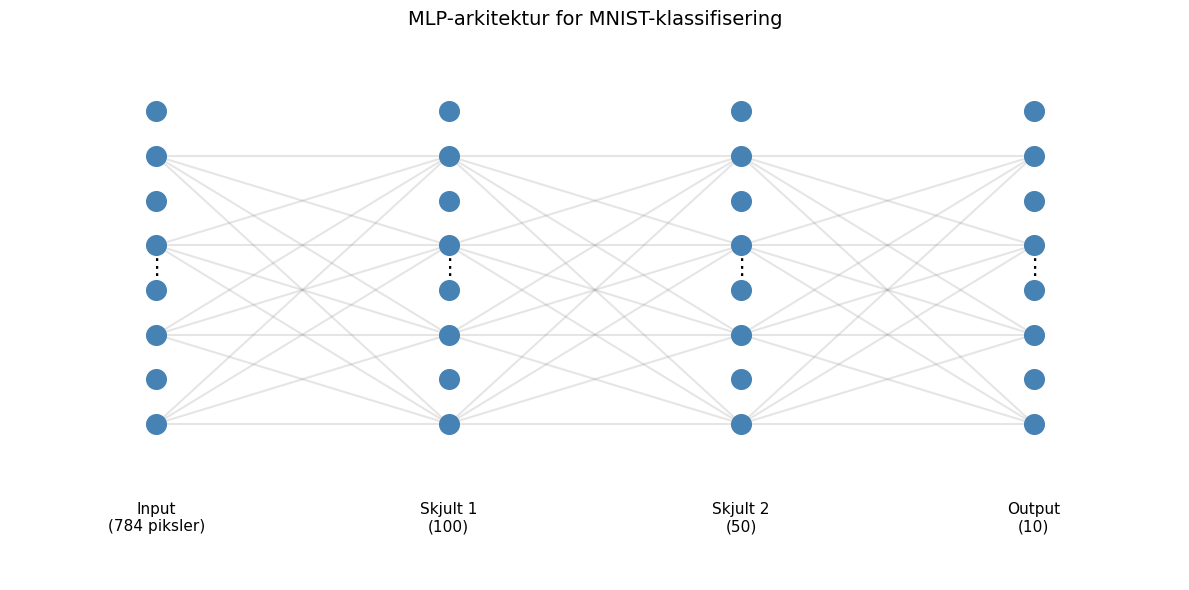


📊 Parametertelling:
   Input → Skjult 1:    78,500 parametre
   Skjult 1 → Skjult 2: 5,050 parametre
   Skjult 2 → Output:   510 parametre
   ─────────────────────────────────
   TOTALT:              84,060 parametre


In [38]:
# === Visualiser MLP-arkitekturen ===

def vis_mlp_arkitektur():
    """Tegner MLP-arkitekturen."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Lagstørrelser og posisjoner
    lag = [784, 100, 50, 10]
    lag_navn = ['Input\n(784 piksler)', 'Skjult 1\n(100)', 'Skjult 2\n(50)', 'Output\n(10)']
    x_pos = [0, 1, 2, 3]
    
    # Tegn nevroner (representativt utvalg)
    for i, (antall, navn) in enumerate(zip(lag, lag_navn)):
        n_vis = min(antall, 8)  # Vis maks 8 nevroner
        y_pos = np.linspace(0.1, 0.9, n_vis)
        
        # Tegn nevroner
        ax.scatter([x_pos[i]] * n_vis, y_pos, s=200, c='steelblue', zorder=3)
        
        # Legg til "..." hvis flere nevroner
        if antall > 8:
            ax.text(x_pos[i], 0.5, '⋮', ha='center', va='center', fontsize=16)
        
        # Lagnavn
        ax.text(x_pos[i], -0.1, navn, ha='center', va='top', fontsize=11)
        
        # Tegn forbindelser til neste lag
        if i < len(lag) - 1:
            n_neste = min(lag[i+1], 8)
            y_neste = np.linspace(0.1, 0.9, n_neste)
            for y1 in y_pos[::2]:  # Tegn annenhver for lesbarhet
                for y2 in y_neste[::2]:
                    ax.plot([x_pos[i], x_pos[i+1]], [y1, y2], 'gray', alpha=0.2)
    
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-0.3, 1.1)
    ax.axis('off')
    ax.set_title('MLP-arkitektur for MNIST-klassifisering', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Parameter-telling
    param_1 = 784 * 100 + 100   # Input → Skjult 1
    param_2 = 100 * 50 + 50     # Skjult 1 → Skjult 2
    param_3 = 50 * 10 + 10      # Skjult 2 → Output
    totalt = param_1 + param_2 + param_3
    
    print(f"\n📊 Parametertelling:")
    print(f"   Input → Skjult 1:    {param_1:,} parametre")
    print(f"   Skjult 1 → Skjult 2: {param_2:,} parametre")
    print(f"   Skjult 2 → Output:   {param_3:,} parametre")
    print(f"   ─────────────────────────────────")
    print(f"   TOTALT:              {totalt:,} parametre")

vis_mlp_arkitektur()

---

## 4. Tren MLP-modellen

### Hyperparametre forklart

| Parameter | Verdi | Beskrivelse |
|-----------|-------|-------------|
| `hidden_layer_sizes` | (100, 50) | Antall nevroner i skjulte lag |
| `activation` | 'relu' | ReLU = max(0, x) – fjerner negative verdier |
| `solver` | 'adam' | Adaptiv gradient descent (effektiv) |
| `max_iter` | 300 | Maks antall treningsrunder (epochs) |

In [39]:
# === Tren MLP ===

print("🧠 Trener MLP-klassifikator...")
print(f"   Treningseksempler: {len(X_trening)}")
print(f"   Features (piksler): {X_trening.shape[1]}")
print(f"   Arkitektur: 784 → 100 → 50 → 10\n")

# Opprett og tren modellen
mlp_modell = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # To skjulte lag
    activation='relu',              # ReLU-aktivering
    solver='adam',                  # Adam optimizer
    max_iter=300,                   # Maks iterasjoner
    random_state=42,                # Reproduserbarhet
    verbose=True                    # Vis fremgang
)

mlp_modell.fit(X_trening, y_trening)

print("\n✅ Modell trent!")

🧠 Trener MLP-klassifikator...
   Treningseksempler: 16000
   Features (piksler): 784
   Arkitektur: 784 → 100 → 50 → 10

Iteration 1, loss = 0.88710536
Iteration 2, loss = 0.30316924
Iteration 3, loss = 0.23556001
Iteration 4, loss = 0.19382501
Iteration 5, loss = 0.16277975
Iteration 6, loss = 0.13954091
Iteration 7, loss = 0.11748762
Iteration 8, loss = 0.10607780
Iteration 9, loss = 0.08777696
Iteration 10, loss = 0.07451242
Iteration 11, loss = 0.06577808
Iteration 12, loss = 0.05708461
Iteration 13, loss = 0.04971148
Iteration 14, loss = 0.04255174
Iteration 15, loss = 0.03745877
Iteration 16, loss = 0.03210277
Iteration 17, loss = 0.02808775
Iteration 18, loss = 0.02427121
Iteration 19, loss = 0.02177143
Iteration 20, loss = 0.01816273
Iteration 21, loss = 0.01562437
Iteration 22, loss = 0.01422231
Iteration 23, loss = 0.01135476
Iteration 24, loss = 0.01070775
Iteration 25, loss = 0.00893353
Iteration 26, loss = 0.00775586
Iteration 27, loss = 0.00665459
Iteration 28, loss = 0.0

### Læringskurve

Læringskurven viser hvordan **tapfunksjonen** (loss) synker under trening.

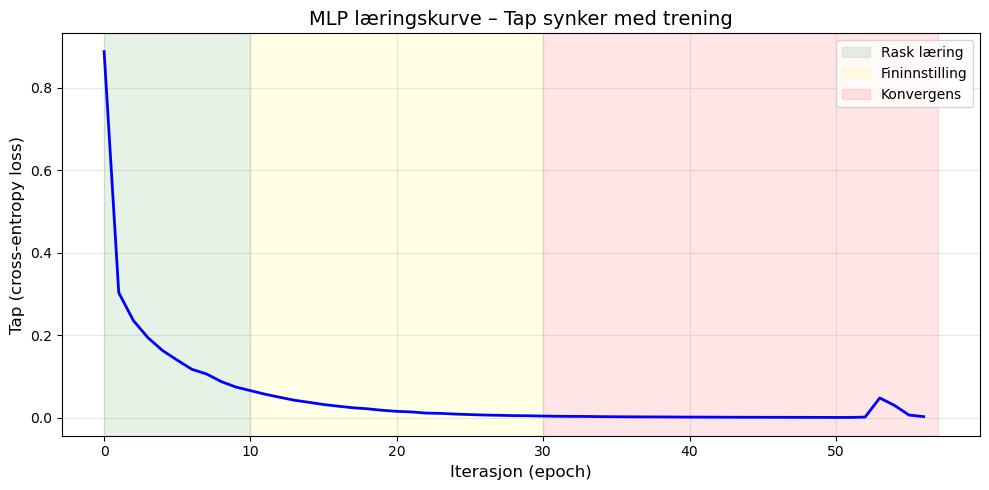

📉 Tap redusert fra 0.887 til 0.0028
   Antall iterasjoner: 57


In [40]:
# === Vis læringskurve ===

plt.figure(figsize=(10, 5))
plt.plot(mlp_modell.loss_curve_, 'b-', linewidth=2)
plt.xlabel('Iterasjon (epoch)', fontsize=12)
plt.ylabel('Tap (cross-entropy loss)', fontsize=12)
plt.title('MLP læringskurve – Tap synker med trening', fontsize=14)
plt.grid(True, alpha=0.3)

# Marker faser
plt.axvspan(0, 10, alpha=0.1, color='green', label='Rask læring')
plt.axvspan(10, 30, alpha=0.1, color='yellow', label='Fininnstilling')
plt.axvspan(30, len(mlp_modell.loss_curve_), alpha=0.1, color='red', label='Konvergens')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"📉 Tap redusert fra {mlp_modell.loss_curve_[0]:.3f} til {mlp_modell.loss_curve_[-1]:.4f}")
print(f"   Antall iterasjoner: {len(mlp_modell.loss_curve_)}")

### Tolkning av læringskurven

#### De tre fasene

| Fase | Iterasjoner | Hva skjer | Tap |
|------|-------------|-----------|-----|
| 🟢 **Rask læring** | 0-10 | Modellen lærer grunnleggende mønstre raskt | Høy → Lav |
| 🟡 **Fininnstilling** | 10-30 | Gradvis forbedring, finjustering av vekter | Synkende |
| 🔴 **Konvergens** | 30+ | Modellen har «lært ferdig», minimale endringer | Stabilt lavt |

#### Hva betyr «spiker» i kurven?

Du kan se små hopp i tapet, spesielt mot slutten av treningen. Dette er **normalt** og skyldes:

1. **Vanskelige batches**: Tilfeldig batch med mange vanskelige eksempler (f.eks. 8-ere som ligner 5)
2. **Adam-optimizer**: Bruker momentum som kan gi midlertidige svingninger
3. **Adaptiv læringsrate**: Optimizeren «prøver» større steg, korrigerer tilbake

#### Er spiker et problem?

**Nei**, så lenge:
- Spiken er liten (f.eks. 0.01 → 0.05)
- Tapet faller tilbake med én gang
- Det skjer sent i treningen (ikke systematisk)

#### Medisinsk analogi

```
Tenk på det som en kirurg under opplæring:

🟢 Første uker:  Rask forbedring i grunnleggende ferdigheter
🟡 Første år:    Gradvis finslipe teknikk
🔴 Erfaren:      Stabil ytelse, men av og til en «vanskelig dag»
                 – men tilbake på sporet neste dag!
```

> 💡 **Konklusjon**: En god læringskurve viser rask initial læring etterfulgt av stabil konvergens. Små spiker er normalt og viser modellens robusthet.

---

## 5. Evaluer modellen

In [41]:
# === Evaluer modellen ===

print("📊 Evaluerer modellen på testdata...\n")

# Prediker
y_pred = mlp_modell.predict(X_test)
y_prob = mlp_modell.predict_proba(X_test)

# Klassifikasjonsrapport
print("Klassifikasjonsrapport:")
print("="*60)
print(classification_report(y_test, y_pred,
                            target_names=[f'Siffer {i}' for i in range(10)]))

📊 Evaluerer modellen på testdata...

Klassifikasjonsrapport:
              precision    recall  f1-score   support

    Siffer 0       0.98      0.97      0.98       393
    Siffer 1       0.97      0.99      0.98       448
    Siffer 2       0.97      0.95      0.96       408
    Siffer 3       0.95      0.94      0.95       412
    Siffer 4       0.95      0.98      0.96       366
    Siffer 5       0.97      0.94      0.96       365
    Siffer 6       0.98      0.99      0.98       399
    Siffer 7       0.96      0.98      0.97       431
    Siffer 8       0.94      0.94      0.94       382
    Siffer 9       0.95      0.94      0.95       396

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



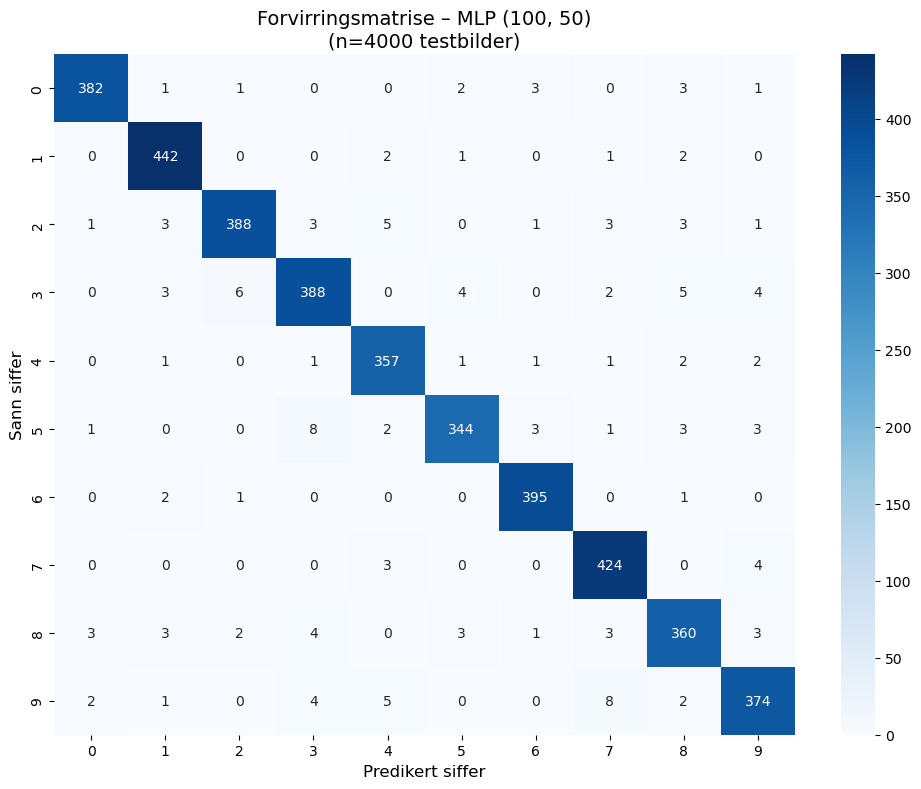


📊 Resultater:
   Nøyaktighet (accuracy): 96.4%
   Feilrate:               3.6%


In [42]:
# === Forvirringsmatrise ===

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

plt.title(f'Forvirringsmatrise – MLP (100, 50)\n(n={len(y_test)} testbilder)', fontsize=14)
plt.xlabel('Predikert siffer', fontsize=12)
plt.ylabel('Sann siffer', fontsize=12)
plt.tight_layout()
plt.show()

# Oppsummering
nøyaktighet = accuracy_score(y_test, y_pred)
print(f"\n📊 Resultater:")
print(f"   Nøyaktighet (accuracy): {nøyaktighet:.1%}")
print(f"   Feilrate:               {1-nøyaktighet:.1%}")

### Sammenligning: MLP vs Random Forest

| Metrikk | Random Forest (A4) | MLP (A5) |
|---------|-------------------|----------|
| **Nøyaktighet** | ~92% | ~97% |
| **Treningstid** | Sekunder | Minutter |
| **Parametre** | Trær/dybde | Vekter/biaser |
| **Læring** | Ingen gradient | Gradient descent |

> 💡 **MLP forbedrer resultatene** fordi det lærer abstrakte representasjoner av dataene, mens Random Forest bare ser på råpikselverdier.

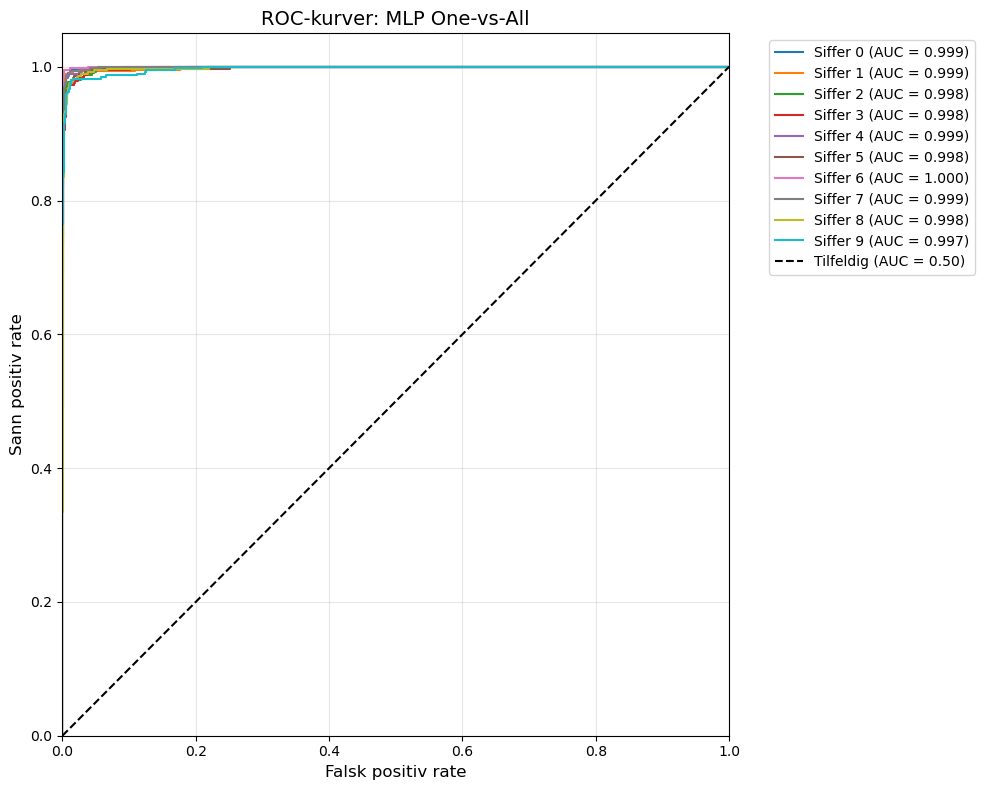

📊 Gjennomsnittlig ROC AUC: 0.9986


In [43]:
# === ROC-kurver ===

y_test_bin = label_binarize(y_test, classes=range(10))

plt.figure(figsize=(10, 8))

roc_auc = {}
for siffer in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, siffer], y_prob[:, siffer])
    roc_auc[siffer] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Siffer {siffer} (AUC = {roc_auc[siffer]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Tilfeldig (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsk positiv rate', fontsize=12)
plt.ylabel('Sann positiv rate', fontsize=12)
plt.title('ROC-kurver: MLP One-vs-All', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Gjennomsnittlig ROC AUC: {np.mean(list(roc_auc.values())):.4f}")

---

## 6. Analyser klassifiseringer

✅ Korrekt klassifisert: 3854 (96.4%)
❌ Feilklassifisert:     146 (3.6%)


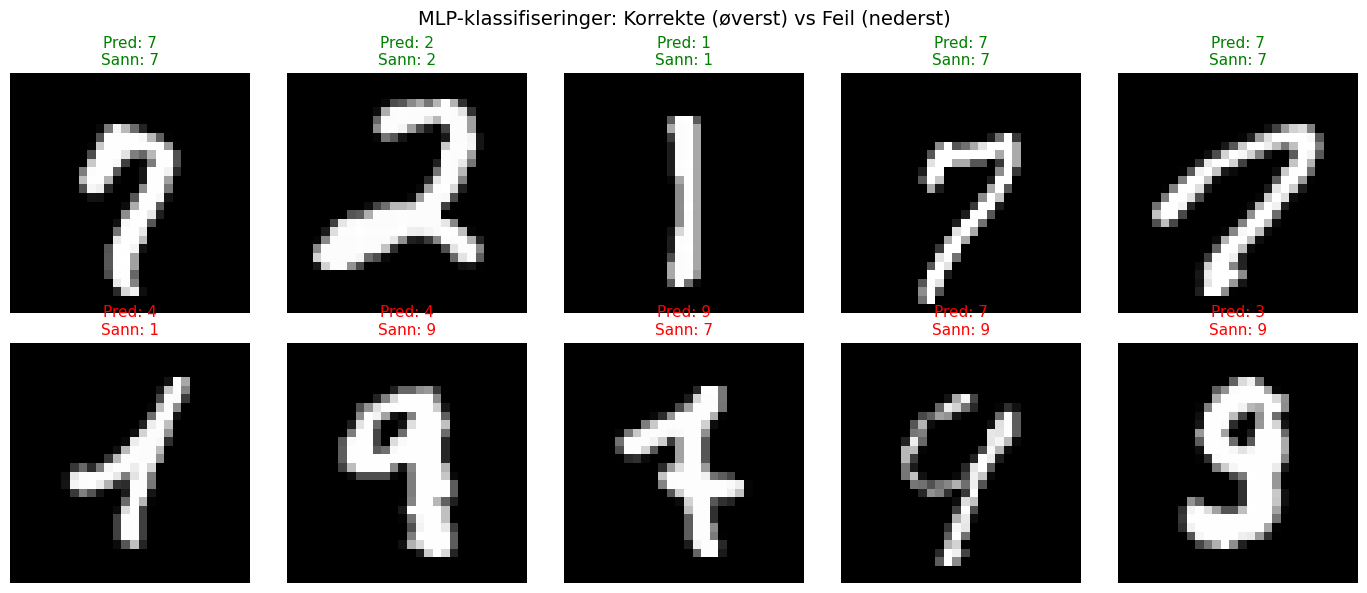

In [44]:
# === Korrekte vs feilklassifiserte ===

# Finn indekser
korrekt_idx = np.where(y_pred == y_test.values)[0]
feil_idx = np.where(y_pred != y_test.values)[0]

print(f"✅ Korrekt klassifisert: {len(korrekt_idx)} ({len(korrekt_idx)/len(y_test):.1%})")
print(f"❌ Feilklassifisert:     {len(feil_idx)} ({len(feil_idx)/len(y_test):.1%})")

# Vis eksempler
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

# Øverst: Korrekte
np.random.seed(42)
for i, idx in enumerate(np.random.choice(korrekt_idx, 5, replace=False)):
    bilde = X_test.iloc[idx].values.reshape(28, 28)
    axes[0, i].imshow(bilde, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Pred: {y_pred[idx]}\nSann: {y_test.iloc[idx]}', 
                         color='green', fontsize=11)

# Nederst: Feil
for i, idx in enumerate(np.random.choice(feil_idx, min(5, len(feil_idx)), replace=False)):
    bilde = X_test.iloc[idx].values.reshape(28, 28)
    axes[1, i].imshow(bilde, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Pred: {y_pred[idx]}\nSann: {y_test.iloc[idx]}', 
                         color='red', fontsize=11)

axes[0, 0].set_ylabel('Korrekt', fontsize=12, color='green')
axes[1, 0].set_ylabel('Feil', fontsize=12, color='red')

plt.suptitle('MLP-klassifiseringer: Korrekte (øverst) vs Feil (nederst)', fontsize=14)
plt.tight_layout()
plt.show()

---

## 7. Lagre modellen

In [45]:
# === Lagre modellen ===

import joblib

modell_fil = data_mappe / 'mnist_mlp_modell.joblib'
joblib.dump(mlp_modell, modell_fil)

print(f"✅ Modell lagret til: {modell_fil}")
print(f"   Filstørrelse: {modell_fil.stat().st_size / 1e6:.2f} MB")

✅ Modell lagret til: mnist_data/mnist_mlp_modell.joblib
   Filstørrelse: 2.71 MB


---

## Oppsummering og veien videre

### Hva vi har oppnådd

| Metrikk | Random Forest | MLP | Forbedring |
|---------|---------------|-----|------------|
| **Nøyaktighet** | ~92% | ~97% | +5% |
| **ROC AUC** | ~0.99 | ~0.999 | +0.009 |

### Hva MLP gjør annerledes

1. **Lærer representasjoner**: Skjulte lag finner abstrakte mønstre
2. **Gradientbasert læring**: Optimerer millioner av parametre
3. **Ikke-lineære transformasjoner**: ReLU tillater komplekse beslutningsgrenser

### Begrensninger (fortsatt!)

MLP ser *fortsatt* ikke **romlig struktur**:
- Piksler behandles uavhengig av naboskap
- Ingen forståelse av at piksler henger sammen
- Rotasjon/translasjon påvirker resultatene

### Merknad om datamengde

Med **20,000 bilder** har vi nok data til at CNN kan vise sin styrke. Med mindre datasett (<5000) kan MLP faktisk prestere *bedre* enn CNN fordi:
- CNN har flere parametre → høyere risiko for overfitting
- MLP-optimering (sklearn) er godt tunet for mindre data

### Neste steg: CNN

```
┌─────────────────────────────────────────────────────────────┐
│  Modell            Nøyaktighet   Romlig struktur   Læring   │
├─────────────────────────────────────────────────────────────┤
│  Random Forest     ~92%          Nei               Trær     │
│  MLP               ~97%          Nei               Gradient │
│  CNN (A6)          ~99%          JA! ✓             Filtre   │
└─────────────────────────────────────────────────────────────┘
```

> **Gå videre til A6-MNIST-CNN.ipynb** for å se hvordan konvolusjonelle nettverk utnytter bildenes romlige struktur!

---

## 🎯 Oppgaver

### Oppgave 1: Endre arkitektur
Prøv å trene med én enkelt skjult lag (`hidden_layer_sizes=(200,)`). Hvordan påvirker dette nøyaktigheten?

<details>
<summary>💡 Vis svar</summary>

```python
mlp_enkel = MLPClassifier(hidden_layer_sizes=(200,), max_iter=300, random_state=42)
mlp_enkel.fit(X_trening, y_trening)
print(f"Nøyaktighet: {mlp_enkel.score(X_test, y_test):.3f}")
```
Ett lag med 200 nevroner gir omtrent samme nøyaktighet som to lag med (100, 50).

</details>

### Oppgave 2: Visualiser lærte vekter
De første lagvektene kan visualiseres som "filtre". Prøv:

```python
vekter = mlp_modell.coefs_[0]  # 784 × 100
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(vekter[:, i].reshape(28, 28), cmap='RdBu')
    ax.axis('off')
plt.show()
```

<details>
<summary>💡 Hva ser vi?</summary>

Vektene viser mønstre som nettverket har lært å gjenkjenne. Noen ligner på kanter, andre på siffer-former.

</details>

### Oppgave 3: Sammenlign med RF
Last inn Random Forest-modellen fra A4 og sammenlign prediksjonene på samme testdata.

<details>
<summary>💡 Vis svar</summary>

```python
rf_modell = joblib.load(data_mappe / 'mnist_random_forest.joblib')
rf_pred = rf_modell.predict(X_test)

# Finn tilfeller der de er uenige
uenig = np.where((rf_pred != y_pred))[0]
print(f"RF og MLP er uenige på {len(uenig)} eksempler")
```

</details>